**Importing Dependencies, and Dataset Manipulation**

In [7]:

#storing and manipulating data
import pandas as pd
import numpy as np

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

#natural language tool kit
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#RoBERTa Model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

In [6]:
df=pd.read_csv('/content/amazon_reviews_dataset_500.csv')

In [11]:
# Downsample the dataset to 500 reviews for analysis
df = df.sample(500)
df['review_text']

,review_text
455,Did NOT like the taste of these. I like all ki...
42,Some really great and some really really bad D...
337,"Excellent Country Ham Slices I love, love, lov..."
263,AWesome! Have had these over the past few year...
79,"Goji berries I am so disappointed, these berri..."
...,...
48,This is How Chocolate Bars SHOULD be A lusciou...
375,You mean I can pig out on these things and not...
466,Bold enough. I love chex mix. Its got more var...
454,My favorite morning drink. Love this tea. What...


**Exploratory Data Analysis**

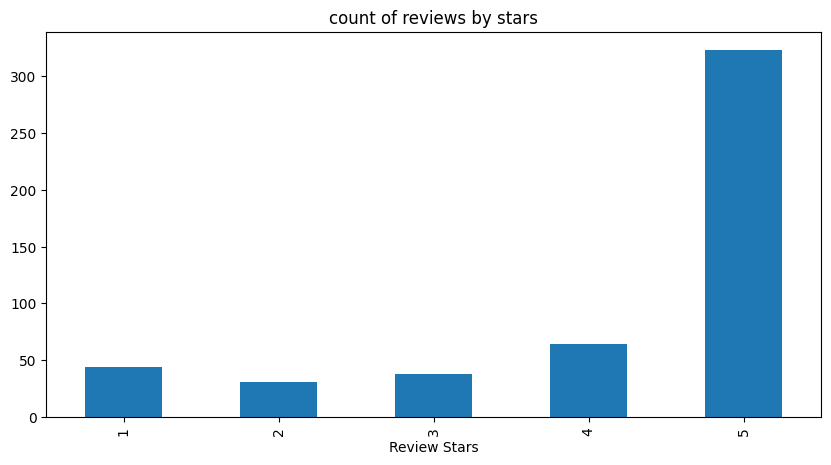

In [12]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar')
ax.set_xlabel('Review Stars')
plt.title('count of reviews by stars')
plt.show()

Data is not balanced!

In [13]:
example=df['review_text'][23]

In [14]:
print(example)

Dogs Love All 3 of my dogs-pom, yorkie, rat terrier, love these. I just received my 2nd order. Wish these were on sub. and save.


In [16]:
import nltk
nltk.download('punkt')

# Now tokenize
tokens = nltk.word_tokenize(example)
print(tokens[:8])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['Dogs', 'Love', 'All', '3', 'of', 'my', 'dogs-pom', ',']


In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')

#find the part of speech for each of the token words with nltk
#each word will get a part of speech value associated with them
#and they are represented with codes like NN is for singular nouns
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('Dogs', 'NNS'),
 ('Love', 'NNP'),
 ('All', 'NNP'),
 ('3', 'CD'),
 ('of', 'IN'),
 ('my', 'PRP$'),
 ('dogs-pom', 'NN'),
 (',', ','),
 ('yorkie', 'NN'),
 (',', ',')]

In [22]:
import nltk

# Download the required NLTK resources
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Assuming you already have 'tagged' defined (a list of tokenized and POS-tagged words)
# Group the tagged words into named entity chunks
entities = nltk.chunk.ne_chunk(tagged)

# Print the entities in a readable format
entities.pprint()


(S
  Dogs/NNS
  (PERSON Love/NNP All/NNP)
  3/CD
  of/IN
  my/PRP$
  dogs-pom/NN
  ,/,
  yorkie/NN
  ,/,
  rat/NN
  terrier/NN
  ,/,
  love/IN
  these/DT
  ./.
  I/PRP
  just/RB
  received/VBD
  my/PRP$
  2nd/CD
  order/NN
  ./.
  Wish/VB
  these/DT
  were/VBD
  on/IN
  sub/NN
  ./.
  and/CC
  save/VB
  ./.)


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


**Sentiment Scoring with VADER**

In [26]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia  =SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [27]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.936}

In [28]:
sia.polarity_scores('Hyuna is getting married! I am so happy!!')

{'neg': 0.0, 'neu': 0.516, 'pos': 0.484, 'compound': 0.7662}

In [29]:
sia.polarity_scores('I am so happy!!')

{'neg': 0.0, 'neu': 0.304, 'pos': 0.696, 'compound': 0.6785}

As seen above this method of sentiment analysis does not account for sentences!

In [30]:
sia.polarity_scores('I am so sad!!')

{'neg': 0.665, 'neu': 0.335, 'pos': 0.0, 'compound': -0.6094}

In [31]:
sia.polarity_scores('hey, I hate you, just kidding you know I love you!')

{'neg': 0.237, 'neu': 0.385, 'pos': 0.378, 'compound': 0.2942}

Compund scores are ranked between 1 and -1, full positive and full negative.

In [35]:
res ={}
for i, row in tqdm(df.iterrows(), total=len(df)):
  text = row['review_text']
  res[i] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
vaders = pd.DataFrame(res).T
vaders = vaders.merge(df, how = 'left', right_index=True, left_index=True)
vaders.head()

,neg,neu,pos,compound,Score,review_text
455,0.090,0.855,0.056,-0.4195,2,Did NOT like the taste of these. I like all ki...
42,0.081,0.745,0.174,0.9928,5,Some really great and some really really bad D...
337,0.000,0.476,0.524,0.9886,5,"Excellent Country Ham Slices I love, love, lov..."
263,0.021,0.734,0.245,0.9758,5,AWesome! Have had these over the past few year...
79,0.156,0.810,0.034,-0.8433,1,"Goji berries I am so disappointed, these berri..."


Measurement of effectiveness?


One way to evaluate if our model is functioning as expected is by testing an assumption.

We can hypothesize that reviews classified as more positive by the model should correspond to higher star ratings, while those predicted to be more negative should align with lower star ratings.

If this holds true, we can trust the sentiment analysis to accurately reflect how users feel about the products overall.

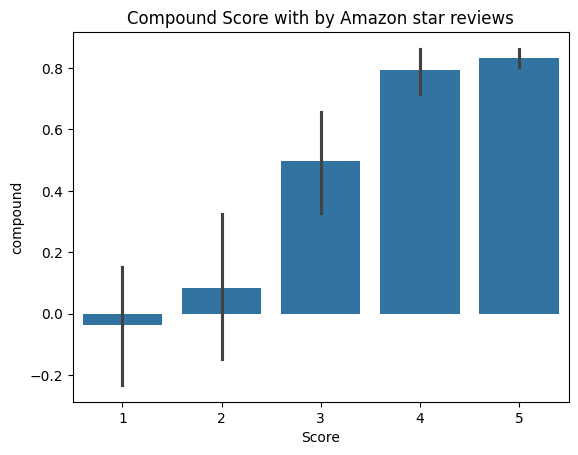

In [37]:
# Plot Vaders results
sns.barplot(data=vaders, x='Score', y='compound')
plt.title('Compound Score with by Amazon star reviews')
plt.show()

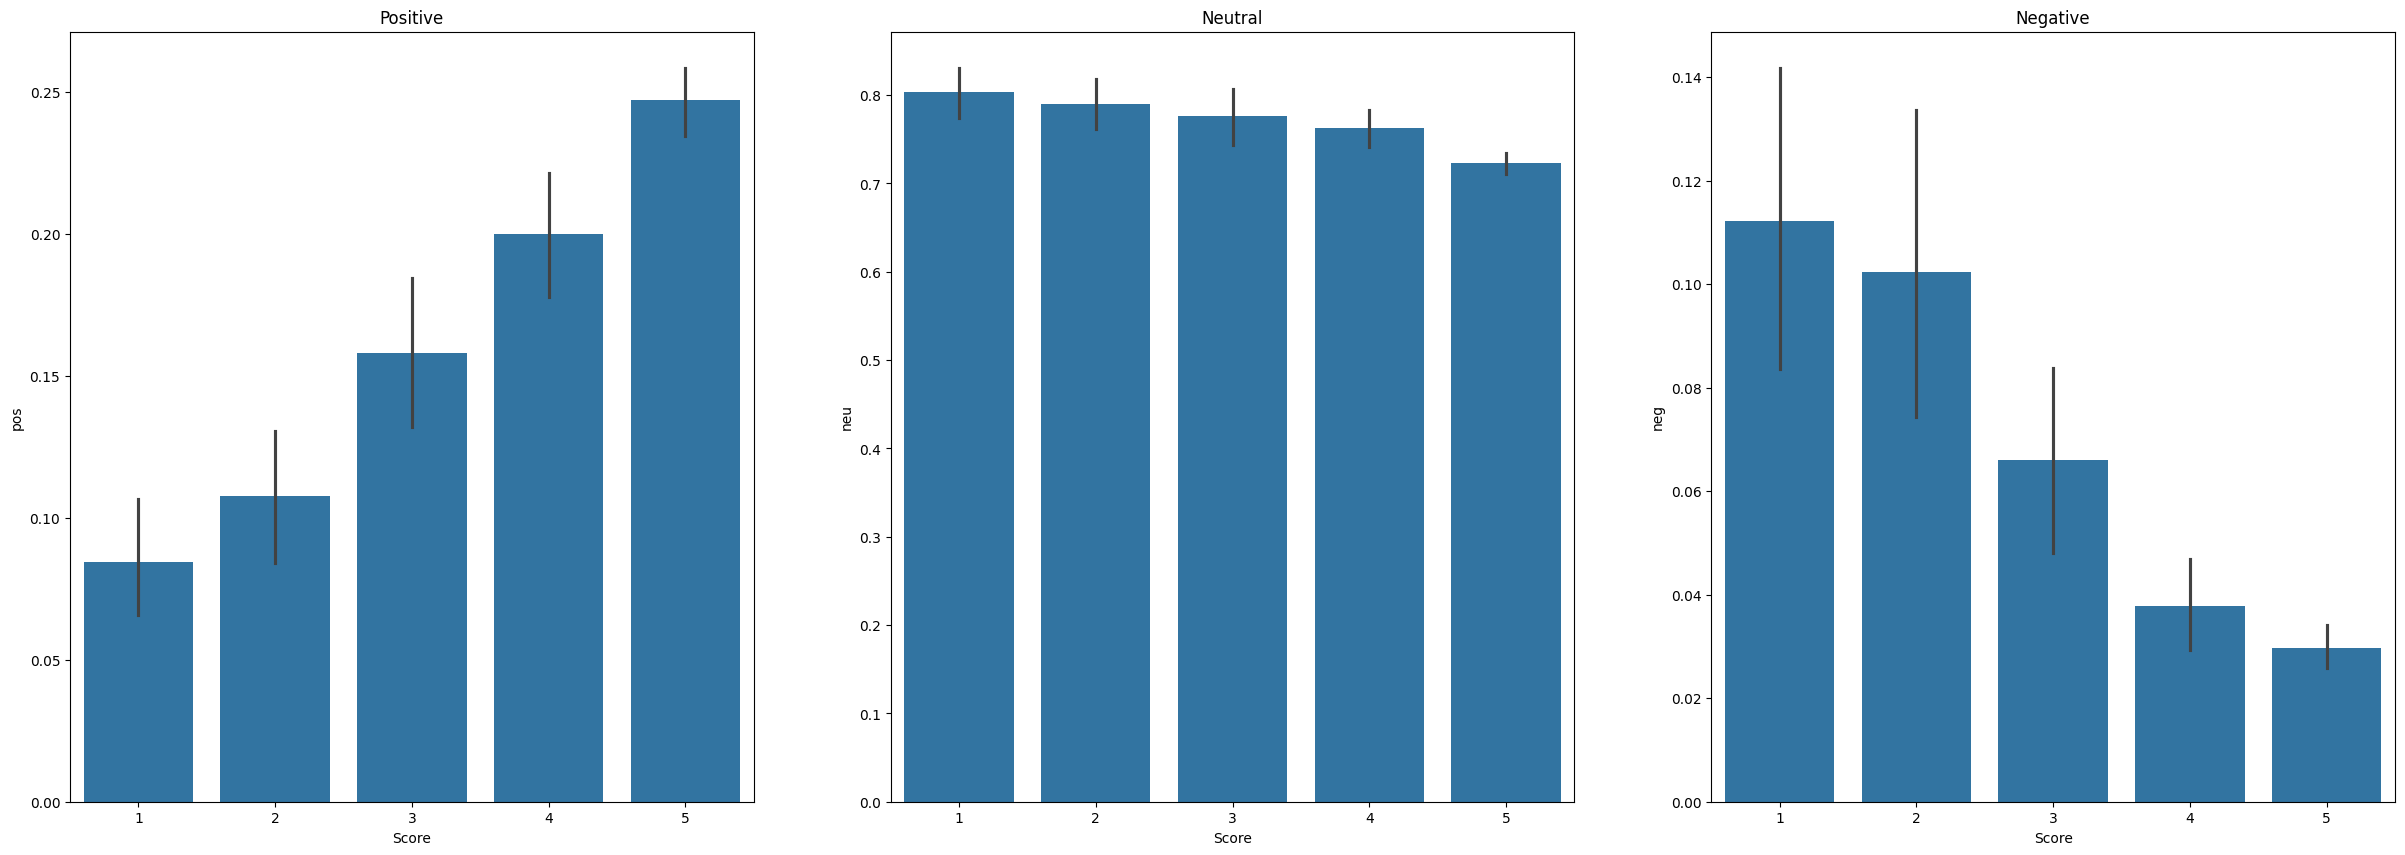

In [38]:

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

**RoBERTa Pretrained Model**

We use a transformer model trained on a massive dataset (hundreds of millions of examples), which captures word meanings in context. This helps handle sarcasm, irony, and complex sentiment. By leveraging pretrained weights from a model designed for tweet sentiment analysis, we apply transfer learning for review sentiment analysis.

In [39]:

model_name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [41]:
#VADER Results on example
print(example)
sia.polarity_scores(example)

Dogs Love All 3 of my dogs-pom, yorkie, rat terrier, love these. I just received my 2nd order. Wish these were on sub. and save.


{'neg': 0.0, 'neu': 0.571, 'pos': 0.429, 'compound': 0.936}

In [42]:
#Run Roberta model for example
encoded_text = tokenizer(example, return_tensors='pt')
encoded_text

{'input_ids': tensor([[    0,   495, 17821,  3437,   404,   155,     9,   127,  3678,    12,
           642,  1075,     6,  1423,  9657,   324,     6, 12378,  8470,  8590,
             6,   657,   209,     4,    38,    95,   829,   127,   132,  1187,
           645,     4, 27383,   209,    58,    15,  2849,     4,     8,  1871,
             4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [44]:
output=model(**encoded_text)


The code output = model(**encoded_text) is part of a common workflow in transformer-based models (like BERT, GPT, etc.), where model is a pre-trained transformer model, and encoded_text is the input text that's been tokenized and converted into a format the model understands (usually as a dictionary containing tensors).

Here’s what the code does:

encoded_text contains the input tokens, typically represented as a dictionary with keys like input_ids, attention_mask, and possibly token_type_ids.

The **encoded_text syntax unpacks the dictionary so that its key-value pairs are passed as arguments to the model function.

model(**encoded_text) runs the encoded input through the model, returning a set of outputs. These outputs can vary depending on the model, but often include things like:

The hidden states or embeddings of the input tokens.
Predicted labels (for classification tasks).
Logits (un-normalized predictions).
The result, output, will typically be a tensor or a set of tensors that represent the model's predictions or intermediate representations of the input text.

In short, the code passes the tokenized input through the model and captures the output, which is typically used for further analysis or predictions.

In [45]:
score = output[0][0].detach().numpy()
score = softmax(score)
score_dict = {
    'Negative': score[0],
    'Neutral': score[1],
    'Positive': score[2]
}
print(score_dict)

{'Negative': 0.0012309735, 'Neutral': 0.010687721, 'Positive': 0.98808134}


In [46]:
print(f"User's actual given star review on the example: {df['Score'][50]}")


User's actual given star review on the example: 4


In [51]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    score = output[0][0].detach().numpy()
    score = softmax(score)
    score_dict = {
        'roberta_neg': score[0],
        'roberta_neu': score[1],
        'roberta_pos': score[2],
    }

    return score_dict


In [52]:
results = {}
for idx, row in tqdm(df.iterrows(), total=len(df)):

    text = row['review_text']

    #Roberta Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    vader_result = sia.polarity_scores(text)
    #rename the results of vader
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f'vader_{key}'] = value

    #making predictions using roberta model
    roberta_result = polarity_scores_roberta(text)

    #combine both results
    result = vader_result_rename | roberta_result

    results[idx] = result

  0%|          | 0/500 [00:00<?, ?it/s]

In [53]:
results_df = pd.DataFrame(results).T
results_df = results_df.merge(df, how = 'left', right_index=True, left_index=True)
results_df.head()

,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Score,review_text
455,0.109,0.847,0.043,-0.6092,0.803013,0.168174,0.028814,2,Did NOT like the taste of these. I like all ki...
42,0.083,0.657,0.260,0.9591,0.125533,0.249860,0.624607,5,Some really great and some really really bad D...
337,0.000,0.476,0.524,0.9886,0.001891,0.007947,0.990162,5,"Excellent Country Ham Slices I love, love, lov..."
263,0.021,0.734,0.245,0.9758,0.001479,0.009472,0.989049,5,AWesome! Have had these over the past few year...
79,0.156,0.810,0.034,-0.8433,0.972884,0.024154,0.002963,1,"Goji berries I am so disappointed, these berri..."


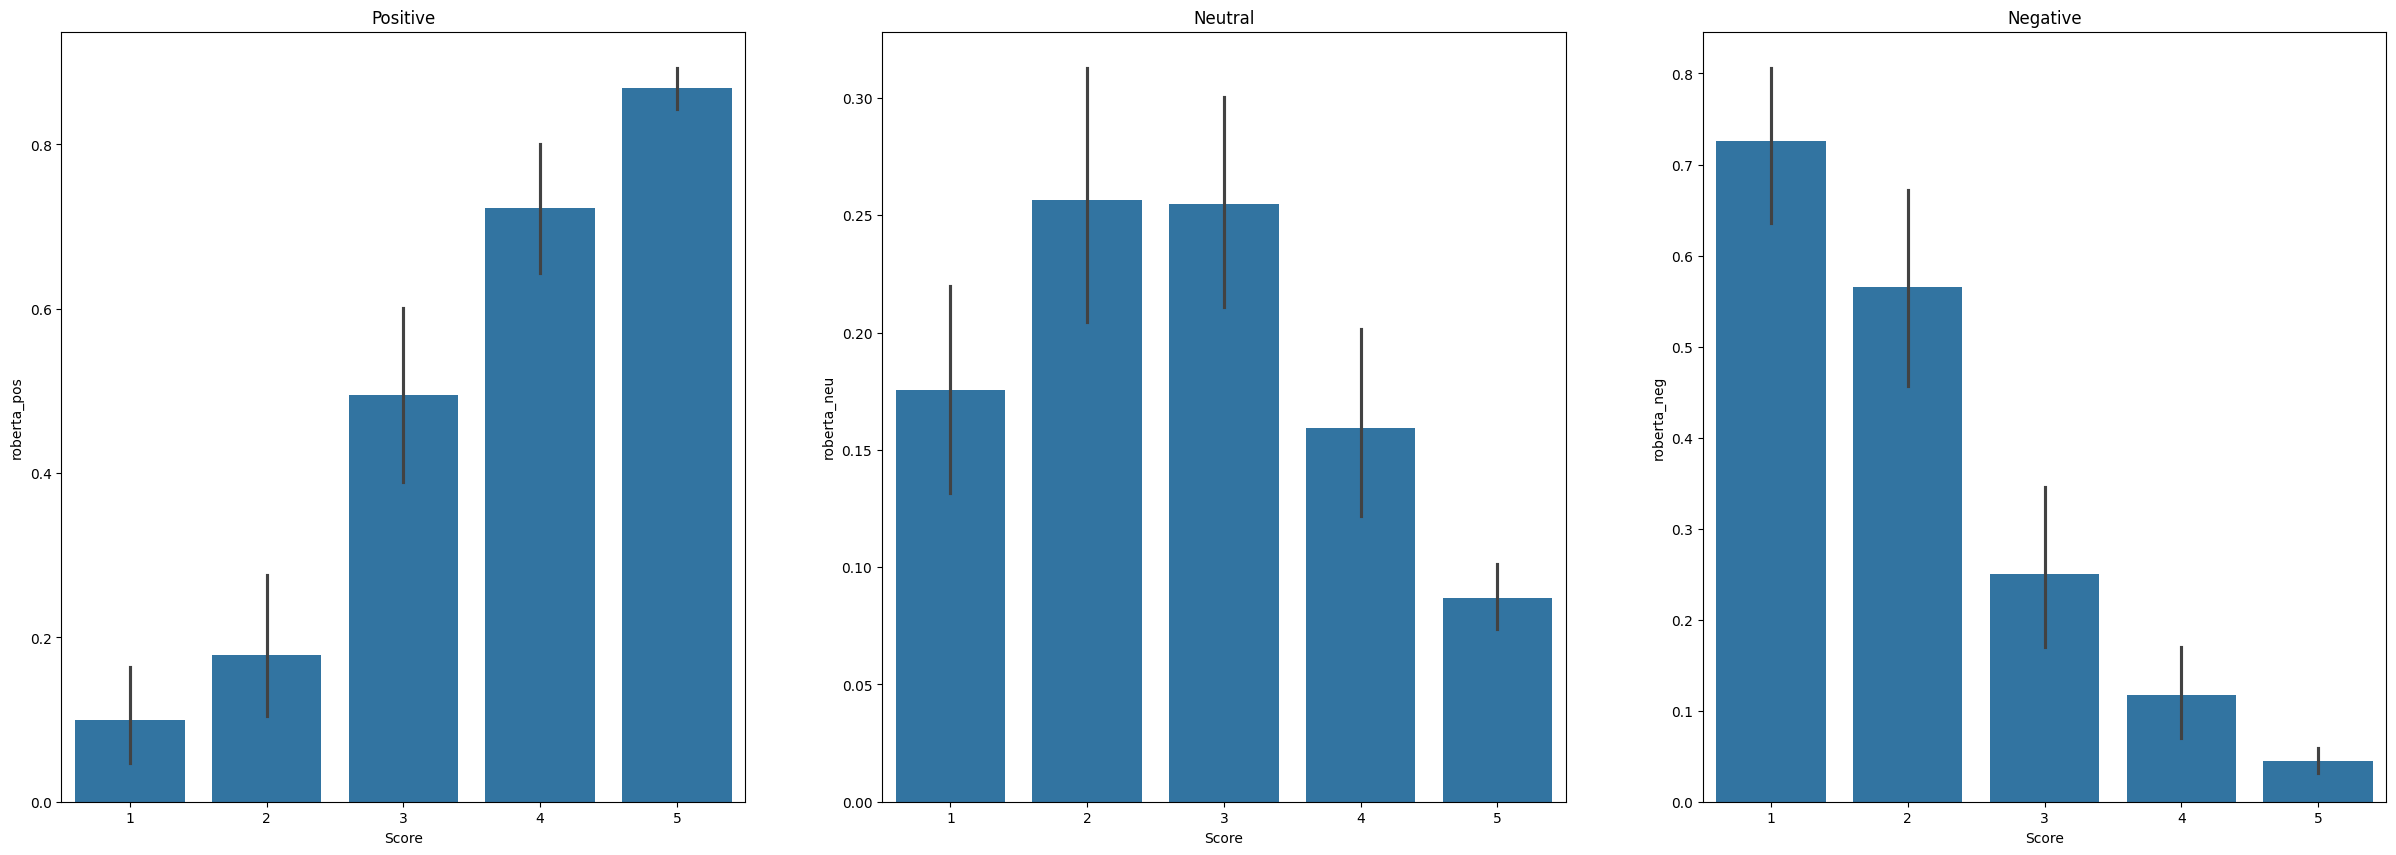

In [54]:
# Plot Roberta results
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()


With the RoBERTa model, there's a clearer trend: as positivity scores rise, star ratings increase, and negative sentiment drops significantly with higher star reviews. This gives a better understanding of user sentiment through text prediction.

False Positive Reviews

In [55]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['review_text'].values[0]

"YUCH! Impressed,as always,with Amazon's expedient delivery. I perused customer reviews before ordering and felt comfortable with my choice (I was going to get the Emeril Bourbon Street blend , which I love) as reviewers gave this a great rating. I find it strong but bitter as opposed to strong and rich. Would not recommend this blend to anyone. No negatives to Amazon but wonder who could find this a pleasurable coffee."

In [56]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['review_text'].values[0]

"YUCH! Impressed,as always,with Amazon's expedient delivery. I perused customer reviews before ordering and felt comfortable with my choice (I was going to get the Emeril Bourbon Street blend , which I love) as reviewers gave this a great rating. I find it strong but bitter as opposed to strong and rich. Would not recommend this blend to anyone. No negatives to Amazon but wonder who could find this a pleasurable coffee."

False Negative Reviews

In [57]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['review_text'].values[0]

"Miss those nuts Really enjoy those Redskins. Realy disappointment that Planters discontinued those big cans. Now I have to buy small ones frequently. Let's get them back."

In [58]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['review_text'].values[0]

"price warp Exceptional coffee, but now priced out of my league.  This is the most totally unreasonable price hike I've seen in a long while--anywhere for anything."

**BERT the Walls!!!**

In [60]:
ratings_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
ratings_tokenizer = AutoTokenizer.from_pretrained(ratings_model_name)
ratings_model = AutoModelForSequenceClassification.from_pretrained(ratings_model_name)

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [59]:
print("Example review:", example)
print("\nActual Rating:", df['Score'][23])

Example review: Dogs Love All 3 of my dogs-pom, yorkie, rat terrier, love these. I just received my 2nd order. Wish these were on sub. and save.

Actual Rating: 5


In [61]:
ratings_encoded_text = ratings_tokenizer(example, return_tensors='pt')
ratings_encoded_text

ratings_output = ratings_model(**ratings_encoded_text)
ratings_output.logits[0].detach().numpy()


ratings_pred = np.argmax(ratings_output.logits[0].detach().numpy()) + 1
print("Predicted Star rating:", ratings_pred)

Predicted Star rating: 5


In [62]:
def rating_prediction_bert(text):
    ratings_encoded_text = ratings_tokenizer(text, return_tensors='pt')
    res = ratings_model(**ratings_encoded_text)
    rating = np.argmax(res.logits[0].detach().numpy()) + 1

    return {'rating' : rating}

In [63]:

ratings_results = {}
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_text']

    #BERT Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    #making rating predictions using bert model
    rating_prediction = rating_prediction_bert(text)

    ratings_results[idx] = rating_prediction

  0%|          | 0/500 [00:00<?, ?it/s]

In [64]:
ratings_df = pd.DataFrame(ratings_results).T
ratings_df = ratings_df.merge(df, how = 'left', right_index=True, left_index=True)
ratings_df.head()

,rating,Score,review_text
455,2,2,Did NOT like the taste of these. I like all ki...
42,3,5,Some really great and some really really bad D...
337,5,5,"Excellent Country Ham Slices I love, love, lov..."
263,5,5,AWesome! Have had these over the past few year...
79,1,1,"Goji berries I am so disappointed, these berri..."


In [65]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(ratings_df['rating'], ratings_df['Score'])
accuracy

0.692

In [66]:
one_off_accuracy = np.where(abs(ratings_df['rating'] - ratings_df['Score']) <= 1, 1, 0).sum() / ratings_df.shape[0]
one_off_accuracy

0.95

We achieve ~70% accuracy in exact rating predictions and 95% accuracy within one star. This demonstrates the model's reliability for understanding user sentiment on new products and services, as well as analyzing existing products or businesses.